<a href="https://colab.research.google.com/github/RebelAKL/Analysing-air-quality-using-various-ML-algorithms/blob/main/aqi_analysis(lr_rf_xgboost).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import shap

c:\Users\rebel\anaconda3\envs\aqi_forecasting\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("ananandvihar(24hr).csv")


In [3]:
df.head()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,Benzene,Toluene,RH,WS,WD,SR,BP,AT
0,01-01-2024 00:00,199.56,335.12,38.99,56.29,61.65,18.28,9.33,1.60,17.08,2.31,8.15,75.30,0.41,60.27,127.21,741.94,11.83
1,02-01-2024 00:00,195.91,320.67,46.46,62.58,71.07,19.42,22.19,1.77,17.98,2.20,9.02,72.11,0.54,54.18,135.27,741.98,11.54
2,03-01-2024 00:00,247.44,360.37,69.63,71.08,94.41,25.29,16.65,2.18,15.52,3.43,12.03,84.56,0.51,38.12,119.43,742.00,10.76
3,04-01-2024 00:00,274.06,436.22,91.01,71.07,111.79,34.86,10.11,1.86,14.38,3.17,18.21,81.26,0.32,96.44,111.25,741.96,11.54
4,05-01-2024 00:00,218.28,345.98,66.03,59.13,85.10,42.52,11.37,2.20,15.25,2.75,14.08,84.88,0.32,51.01,79.26,742.00,12.01


In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y %H:%M').dt.date


In [5]:
df.head()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,Benzene,Toluene,RH,WS,WD,SR,BP,AT
0,2024-01-01,199.56,335.12,38.99,56.29,61.65,18.28,9.33,1.60,17.08,2.31,8.15,75.30,0.41,60.27,127.21,741.94,11.83
1,2024-01-02,195.91,320.67,46.46,62.58,71.07,19.42,22.19,1.77,17.98,2.20,9.02,72.11,0.54,54.18,135.27,741.98,11.54
2,2024-01-03,247.44,360.37,69.63,71.08,94.41,25.29,16.65,2.18,15.52,3.43,12.03,84.56,0.51,38.12,119.43,742.00,10.76
3,2024-01-04,274.06,436.22,91.01,71.07,111.79,34.86,10.11,1.86,14.38,3.17,18.21,81.26,0.32,96.44,111.25,741.96,11.54
4,2024-01-05,218.28,345.98,66.03,59.13,85.10,42.52,11.37,2.20,15.25,2.75,14.08,84.88,0.32,51.01,79.26,742.00,12.01


In [6]:
df.to_csv("updated_dataset.csv", index=False)

In [7]:
def calculate_aqi(concentration, c_low, c_high, a_low, a_high):
    if concentration <= c_low:
        return a_low
    elif concentration >= c_high:
        return a_high
    else:
        return a_low + (a_high - a_low) * (concentration - c_low) / (c_high - c_low)

breakpoints = {
    'PM2.5': [(0, 30), (30, 60), (60, 90), (90, 120), (120, 250), (250, 500)],
    'PM10': [(0, 50), (50, 100), (100, 150), (150, 200), (200, 350), (350, 500)],
    'NO2': [(0, 40), (40, 80), (80, 180), (180, 280), (280, 400), (400, 800)],
    'Ozone': [(0, 50), (50, 100), (100, 160), (160, 200), (200, 300), (300, 400)],
    'CO': [(0, 2), (2, 5), (5, 10), (10, 20), (20, 30), (30, 50)],
    'SO2': [(0, 40), (40, 80), (80, 380), (380, 800), (800, 1600), (1600, 2000)],
}


for pollutant, limits in breakpoints.items():
    for i, (low, high) in enumerate(limits):
        df[f'{pollutant}_AQI'] = df.apply(
            lambda row: calculate_aqi(row[pollutant], low, high, i * 50, (i + 1) * 50),
            axis=1
        )


df['AQI'] = df[['PM2.5_AQI', 'PM10_AQI', 'NO2_AQI', 'Ozone_AQI', 'CO_AQI', 'SO2_AQI']].max(axis=1)


print(df[['Date', 'AQI']].head())

         Date         AQI
0  2024-01-01  250.000000
1  2024-01-02  250.000000
2  2024-01-03  253.456667
3  2024-01-04  278.740000
4  2024-01-05  250.000000


In [8]:
df.head()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,...,SR,BP,AT,PM2.5_AQI,PM10_AQI,NO2_AQI,Ozone_AQI,CO_AQI,SO2_AQI,AQI
0,2024-01-01,199.56,335.12,38.99,56.29,61.65,18.28,9.33,1.60,17.08,...,127.21,741.94,11.83,250.000,250.000000,250.0,250.0,250.0,250.0,250.000000
1,2024-01-02,195.91,320.67,46.46,62.58,71.07,19.42,22.19,1.77,17.98,...,135.27,741.98,11.54,250.000,250.000000,250.0,250.0,250.0,250.0,250.000000
2,2024-01-03,247.44,360.37,69.63,71.08,94.41,25.29,16.65,2.18,15.52,...,119.43,742.00,10.76,250.000,253.456667,250.0,250.0,250.0,250.0,253.456667
3,2024-01-04,274.06,436.22,91.01,71.07,111.79,34.86,10.11,1.86,14.38,...,111.25,741.96,11.54,254.812,278.740000,250.0,250.0,250.0,250.0,278.740000
4,2024-01-05,218.28,345.98,66.03,59.13,85.10,42.52,11.37,2.20,15.25,...,79.26,742.00,12.01,250.000,250.000000,250.0,250.0,250.0,250.0,250.000000


In [9]:
df.dropna(inplace=True)


features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'RH', 'WS', 'WD', 'SR', 'BP', 'AT']
X = df[features]
y = df['AQI']

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [12]:
# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)
print(f"Linear Regression - MSE: {lr_mse}, R²: {lr_r2}")

# 2. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
print(f"Random Forest - MSE: {rf_mse}, R²: {rf_r2}")

# 3. XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)
print(f"XGBoost - MSE: {xgb_mse}, R²: {xgb_r2}")

Linear Regression - MSE: 84.48073545774704, R²: 0.8091566571012159
Random Forest - MSE: 0.09487867687481533, R²: 0.9997856675398659
XGBoost - MSE: 0.5556182036349663, R²: 0.9987448495235917


In [13]:
model_comparisons = {
    'Linear Regression': (lr_mse, lr_r2),
    'Random Forest': (rf_mse, rf_r2),
    'XGBoost': (xgb_mse, xgb_r2),
}

best_model_name, (best_mse, best_r2) = min(model_comparisons.items(), key=lambda x: x[1][0])
print(f"Best model based on MSE: {best_model_name} with MSE: {best_mse}, R²: {best_r2}")


Best model based on MSE: Random Forest with MSE: 0.09487867687481533, R²: 0.9997856675398659


In [14]:
if best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'XGBoost':
    best_model = xgb_model
else:
    best_model = lr_model


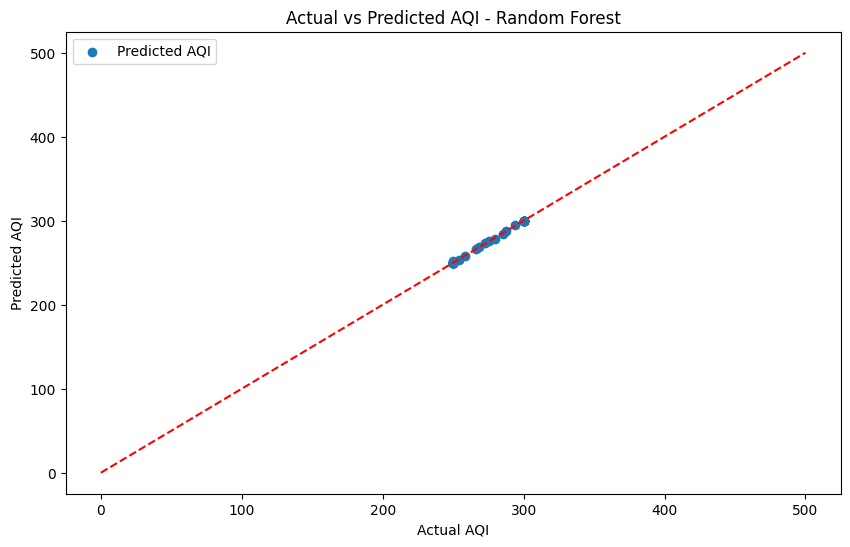

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_model.predict(X_test), label='Predicted AQI')
plt.plot([0, 500], [0, 500], color='red', linestyle='--')  # Ideal line (perfect prediction)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title(f'Actual vs Predicted AQI - {best_model_name}')
plt.legend()
plt.show()

In [16]:

joblib.dump(rf_model, "best_aqi_predictor_model.pkl")


['best_aqi_predictor_model.pkl']

In [17]:
future_steps = 7

forecasted_features = {}
for feature in features:
    seasonal_periods = 7
    try:
        model = ExponentialSmoothing(df[feature], trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        model_fit = model.fit()
        forecasted_features[feature] = model_fit.forecast(future_steps)
    except ValueError as e:
        print(f"Error forecasting {feature}: {e}")
        forecasted_features[feature] = [None] * future_steps


forecasted_df = pd.DataFrame(forecasted_features)


forecasted_features_scaled = scaler.transform(forecasted_df)
future_aqi = best_model.predict(forecasted_features_scaled)


c:\Users\rebel\anaconda3\envs\aqi_forecasting\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\rebel\anaconda3\envs\aqi_forecasting\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rebel\anaconda3\envs\aqi_forecasting\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\rebel\anaconda3\envs\aqi_forecasting\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provid

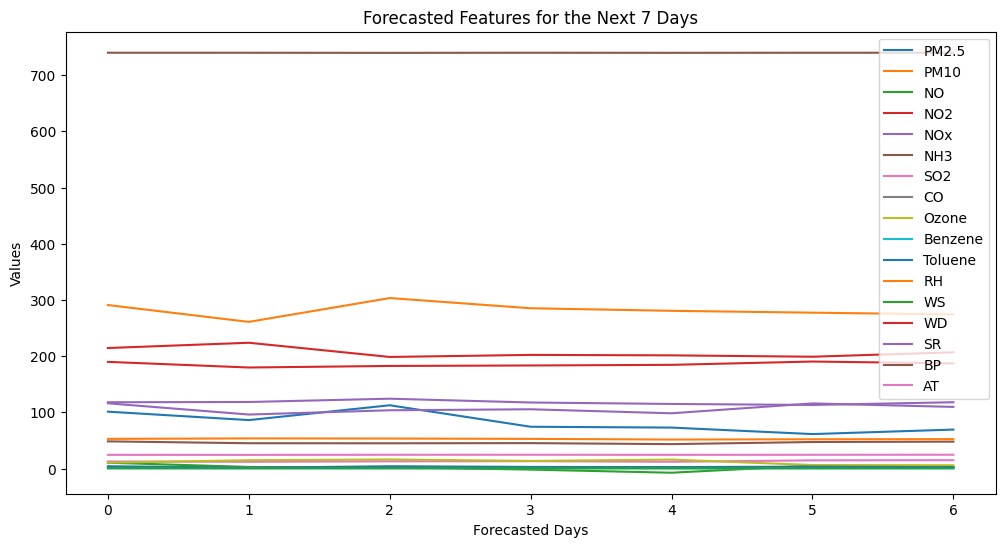

In [18]:
plt.figure(figsize=(12, 6))
for feature, values in forecasted_features.items():
    plt.plot(np.arange(future_steps), values, label=feature)
plt.xlabel('Forecasted Days')
plt.ylabel('Values')
plt.title('Forecasted Features for the Next 7 Days')
plt.legend()
plt.show()

In [19]:
forecasted_df['AQI'] = future_aqi
print(forecasted_df)
forecasted_df.to_csv("forecasted_aqi.csv", index=False)

          PM2.5        PM10         NO         NO2         NOx        NH3  \
299  101.259679  290.952922  10.325501  189.868188  116.142414  48.388475   
300   86.242737  261.012829   2.916173  179.826565   96.116497  45.074460   
301  112.611395  303.385700   2.193885  182.590155  103.725938  44.971847   
302   74.411267  285.285336  -1.875555  183.434110  105.491944  45.258446   
303   72.907734  280.686852  -7.414265  184.569943   98.349268  43.462537   
304   61.352264  277.407430   5.234343  190.451662  115.921930  47.254767   
305   69.351894  274.187877   2.492109  187.153183  109.691419  47.893943   

           SO2        CO      Ozone   Benzene   Toluene         RH        WS  \
299  12.569242  2.363143  10.440874  0.217557  4.111656  52.801842  0.796291   
300  12.038517  2.273433  14.792398  0.117316  1.516373  53.673917  0.755093   
301  12.839941  2.544225  16.194754  0.320521  4.079913  53.423298  0.646079   
302  13.134323  2.483080  13.539926  0.407732  2.932692  52.806

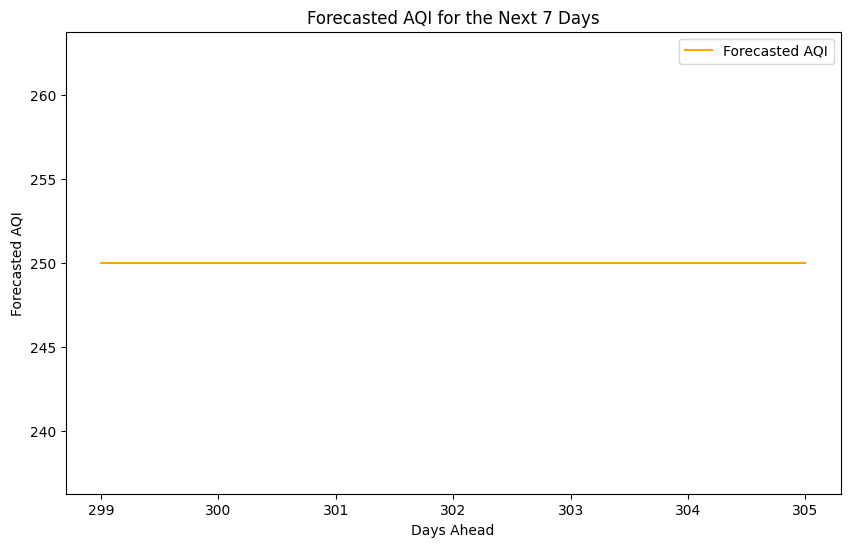

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(forecasted_df.index, forecasted_df['AQI'], label='Forecasted AQI', color='orange')
plt.xlabel('Days Ahead')
plt.ylabel('Forecasted AQI')
plt.title('Forecasted AQI for the Next 7 Days')
plt.legend()
plt.show()

In [21]:
correlation_matrix = df[features + [target]].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap of Features and AQI')
plt.show()

NameError: name 'target' is not defined

In [22]:
print("Scaler expects:", scaler.mean_.shape[0], "features")


Scaler expects: 17 features


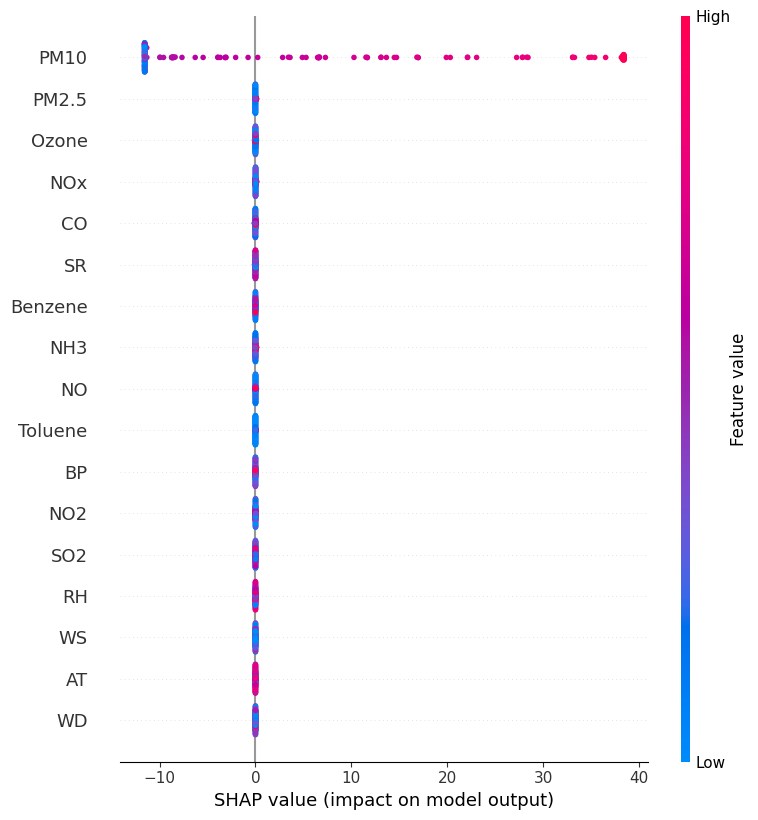

<Figure size 640x480 with 0 Axes>

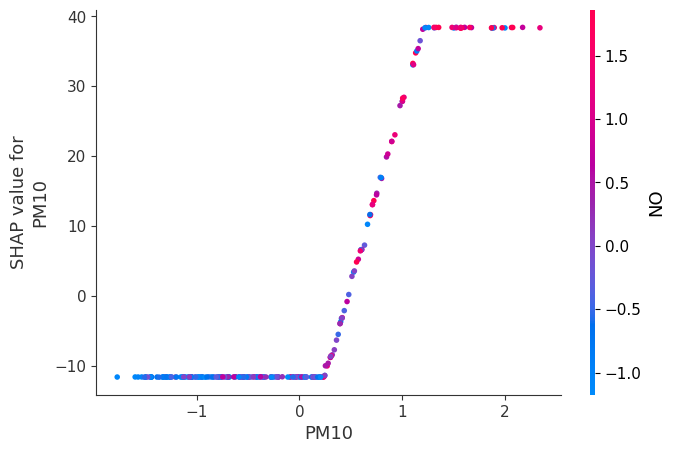

In [ ]:
explainer = shap.TreeExplainer(best_model)


shap_values = explainer.shap_values(X_train)

plt.figure()
shap.summary_plot(shap_values, X_train, feature_names=feature_names)

feature_to_analyze = "PM10"  # Replace with the desired feature name
plt.figure()
shap.dependence_plot(feature_to_analyze, shap_values, X_train, feature_names=feature_names)